In [29]:
%matplotlib inline
import sys
sys.path.append("/Users/edwardlrichards/compAcoustics") 
sys.path.append("/Users/edwardlrichards/swellEx") 

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import swellEx_env
import loadCSDM as cm
from normalMode import Chinook
from beamformers import bartlet, wnc_op

In [30]:
# Experimental data
dataFile = '/Users/edwardlrichards/swellEx/data/J1312315.vla.21els.sio'
fs = 1500
tStart = 1000
snapLength = 1
snapStep = 0.5
sD = 54

In [31]:
f = 49
decimation = 10
fB_width = 300
enviornment = swellEx_env.loadEnviornment()
sensorPosition = swellEx_env.loadArray()

# Match field boundries
zMax = enviornment.getProfile(0.).getZatInterface()[1]
rMax = 1e4  # m

In [32]:
nm_model = Chinook(f, enviornment)
nm_model.calculateModes_eig(fB_width, decimation)

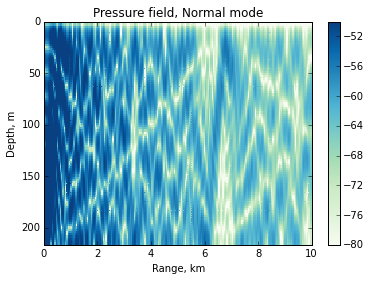

In [33]:
# Plot TL, to make sure everything is working as expected
zPlot = np.r_[0:zMax:100j]
rPlot = np.r_[10:rMax:200j]
sd = float(sensorPosition.tail(1))
p_nm = nm_model.calculatePressure(sd, zPlot, rPlot)

R_nm, Z = np.meshgrid(p_nm.index, p_nm.columns)
TL_nm = 20 * np.log10(np.abs(p_nm.T))
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(TL_nm), cmap = plt.cm.GnBu)
_ = plt.clim(-80, -50)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Pressure field, Normal mode')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

In [34]:
# Construct MF library
lookVectors = np.dstack([nm_model.calculatePressure(d, zPlot, rPlot)\
                 for d in sensorPosition])

# normalize look vectors
lookVectors = lookVectors / np.linalg.norm(lookVectors, axis = 2)[:,:,None]
lookVectors = np.nan_to_num(lookVectors)

# Stack into a m by n grid, where m is number of look position,
# n is number of sensors
shape_3d = lookVectors.shape
lookVectors = np.reshape(lookVectors,\
                         (shape_3d[0] * shape_3d[1], shape_3d[2]))

In [35]:
dataIter = cm.SnapshotLoad(dataFile, fs, tStart, snapLength, snapStep,
                          channelNames = sensorPosition.index)
processingFunction = cm.NarrowBandPressure(f)
kGen = cm.CSDM(dataIter, processingFunction)

In [36]:
K = kGen(20)

In [37]:
B_bart = bartlet(K.iloc[0], lookVectors)
B_bart = np.reshape(B_bart, (shape_3d[0], shape_3d[1]))
B_bart = 10 * np.log10(np.abs(B_bart) + np.spacing(1))
B_bart = B_bart - np.max(B_bart)

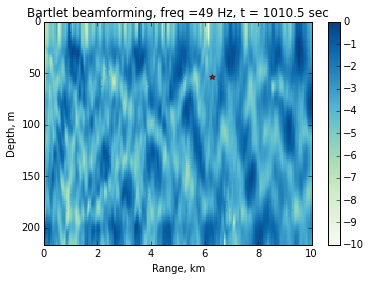

In [38]:
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_bart).T, cmap = plt.cm.GnBu)
_ = plt.clim(-10, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Bartlet beamforming, freq =' + str(f) +\
              ' Hz, t = ' + str(K[f].index.name) + ' sec')
_ = plt.plot(swellEx_env.getRangeAtTime(K[f].index.name), sD, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

In [39]:
%time B_wnc = wnc_op(np.array(K.iloc[0]), lookVectors, 4)
B_wnc = np.reshape(B_wnc, (shape_3d[0], shape_3d[1]))
B_wnc = np.nan_to_num(B_wnc)
B_wnc = 10 * np.log10(np.abs(B_wnc) + np.spacing(1))
B_wnc = B_wnc - np.max(B_wnc)

CPU times: user 21.1 s, sys: 481 ms, total: 21.5 s
Wall time: 21.8 s


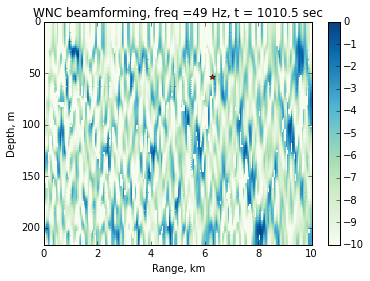

In [40]:
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_wnc).T, cmap = plt.cm.GnBu)
_ = plt.clim(-10, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('WNC beamforming, freq =' + str(f) +\
              ' Hz, t = ' + str(K[f].index.name) + ' sec')
_ = plt.plot(swellEx_env.getRangeAtTime(K[f].index.name), sD, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')